# Week 4: Models

## Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.utils import timeseries_dataset_from_array
from keras import layers, models, Input
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

## Loading Dataset and Preprocessing

In [2]:
df = pd.read_csv("AMZN_2006-01-01_to_2018-01-01.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [3]:
# Convert date
df["Date"] = pd.to_datetime(df["Date"]).map(pd.Timestamp.toordinal)
dates = df["Date"].copy()

# Drop non-numeric column
# df = df.drop(columns=["Name"])
df = df.drop(columns=["Name", "Date"])

# Select input features and target
# feature_cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
feature_cols = ["Open", "High", "Low", "Close", "Volume"]
X_raw = df[feature_cols].values
y_raw = df["Close"].values.reshape(-1, 1)

In [4]:
# Scale inputs
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X_raw)

# Scale target
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y_raw)


## Train-test split

In [5]:
seq_len = 50

X_data = X_scaled        # (N, 5)
y_data = y_scaled        # (N, 1)

# shift target forward by `seq_len`
y_shifted = y_data[seq_len:]
X_trimmed = X_data[:-seq_len]

split = int(len(X_trimmed) * 0.8)

X_train = X_trimmed[:split]
y_train = y_shifted[:split]

X_test = X_trimmed[split:]
y_test = y_shifted[split:]

train_data = tf.keras.utils.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=seq_len,
    sequence_stride=1,
    shuffle=True,
    batch_size=32,
)

test_data = tf.keras.utils.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=seq_len,
    sequence_stride=1,
    shuffle=False,
    batch_size=32,
)


## RNN

In [13]:
model_rnn = models.Sequential([
    Input(shape=(seq_len, 5)),
    layers.SimpleRNN(64, return_sequences=True),  # , input_shape=(seq_len, 5)),
    layers.Dropout(0.2),

    layers.SimpleRNN(64),
    layers.Dropout(0.2),

    layers.Dense(32, activation="relu"),
    layers.Dense(1),
])

model_rnn.compile(optimizer="adam", loss="mse")

history = model_rnn.fit(train_data, epochs=10)

Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 0.0288
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0029
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0019
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0013
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.1727e-04
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.5558e-04
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.6162e-04
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.1960e-04
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 4.4976e-04
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.0557e-04


In [7]:
def plot_train_test_predictions(train, test_true, test_pred, dates, title):
    plt.figure(figsize=(14, 5))

    # X-axis indices
    train_x = np.arange(len(train))
    test_x = np.arange(len(train), len(train) + len(test_true))

    # Plot lines
    plt.plot(train_x, train, label="Training Price")
    plt.plot(test_x, test_true, label="True Test Price")
    plt.plot(test_x, test_pred, label="Predicted Test Price")

    # Convert ordinal dates to actual datetime
    dates = dates.apply(pd.Timestamp.fromordinal)

    # Build date array for the entire plotted range
    all_dates = dates[:len(train) + len(test_true)]

    # Find the FIRST available date of each year
    tick_idx = []
    tick_labels = []
    seen_years = set()

    for i, d in enumerate(all_dates):
        if d.year not in seen_years:
            seen_years.add(d.year)
            tick_idx.append(i)
            tick_labels.append(str(d.year))

    # Apply ticks
    plt.xticks(tick_idx, tick_labels, rotation=45)

    plt.xlabel("Date")
    plt.ylabel("AMZN Close Price ($)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


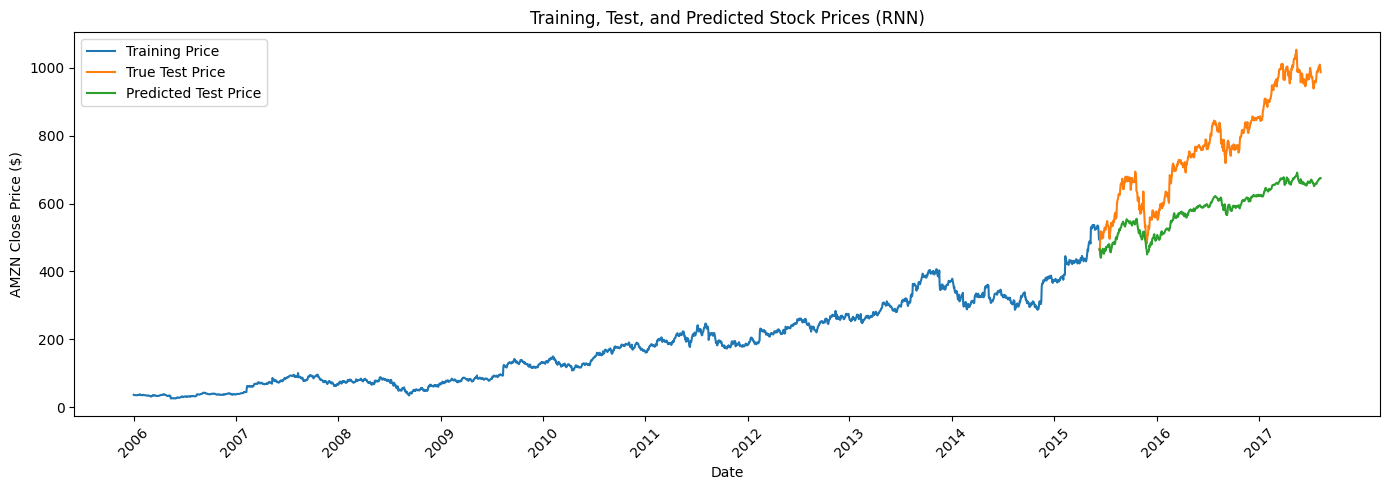

In [19]:
pred_scaled = model_rnn.predict(test_data)
true_scaled = np.concatenate([y for X, y in test_data], axis=0)

pred = target_scaler.inverse_transform(pred_scaled).flatten()
true = target_scaler.inverse_transform(true_scaled).flatten()

data = target_scaler.inverse_transform(y_train).flatten()

plot_train_test_predictions(
    train=data,
    test_true=true,
    test_pred=pred,
    # dates=df["Date"],
    dates=dates,
    title="Training, Test, and Predicted Stock Prices (RNN)"
)


## LSTM

In [22]:
model = models.Sequential([
    Input(shape=(seq_len, 5)),
    layers.LSTM(128, return_sequences=True),  # , input_shape=(seq_len, 5)),
    layers.Dropout(0.2),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")

history = model.fit(train_data, epochs=10)

Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.0033
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 2.1939e-04
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 1.6149e-04
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 1.5622e-04
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 1.5232e-04
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 1.3453e-04
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 1.4774e-04
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 1.2549e-04
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 1.1965e-04
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 1.2277e-04


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


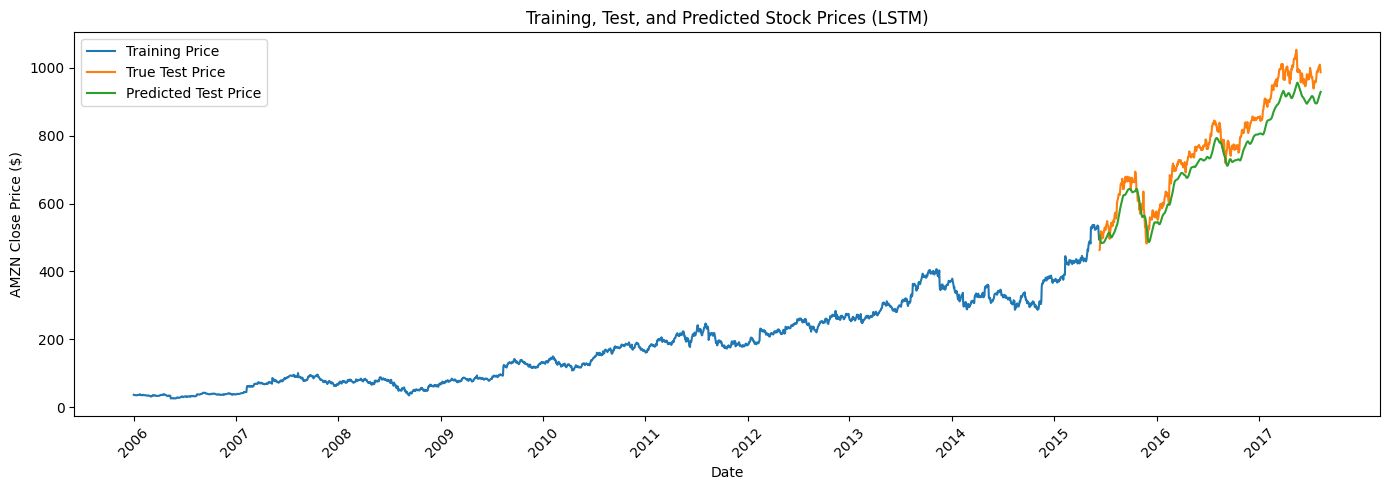

In [11]:
pred_scaled = model.predict(test_data)
true_scaled = np.concatenate([y for X, y in test_data], axis=0)

pred = target_scaler.inverse_transform(pred_scaled).flatten()
true = target_scaler.inverse_transform(true_scaled).flatten()

data = target_scaler.inverse_transform(y_train).flatten()

plot_train_test_predictions(
    train=data,
    test_true=true,
    test_pred=pred,
    # dates=df["Date"],
    dates=dates,
    title="Training, Test, and Predicted Stock Prices (LSTM)"
)
